In [1]:
import pandas as pd
from smartbeta.smartfactor import SmartFactor
from smartbeta.ai_factor import AiFactor
from data_provider.nestlib.market_info import Frequency
from tqdm import tqdm
import pdb
from backtest_batch_service_bartest import backtest_batch_service

In [2]:
class FilterFactor(AiFactor):
    '''
    该类负责将一个因子对另一个因子进行Union操作并留下共有部分的因子
    请使用工具函数generate_filter_factor
    '''

    def _x_rules(self):
        """
        在该方法中指定因子预处理方式
        
        更多方法，参见因子合成文档中的因子标准化方法
        """
        return []

    def _build_ai_model(self, dateTime, training_set):
        """
        按指定frequency，滚动生成复合因子数据
        
        Parameters
        -----------
        dateTime: datetime类型
            当前时间
        trainint_set: pd.DataFrame
            训练集
        Return
        -------
        pd.Series类型，key为securityId, 值为factor value
        """

        ret = self.ff._get_training_XY(dateTime, training_set)
        df_factor=ret[2]

        
        column_name=df_factor.columns
        source_factor_name = self._factor_param['source_factor_name']
        col_name_list = list(column_name)
        col_name_list.remove(source_factor_name)
        filter_factor_name = col_name_list
        
        source_se = df_factor.loc[:,source_factor_name]
        filter_df = df_factor.loc[:,filter_factor_name]
        
        source_se = source_se.reset_index().set_index('security_code')[source_factor_name]
        
        filter_factor_cut_part = self._factor_param['cut_part']
        filter_factor_percentile = self._factor_param['percentile']

        filter_df = filter_df.rank(pct=True, axis=0)
        filter_df = filter_df.reset_index().set_index('security_code')

        tickers_to_drop = []
        for filter_name in tqdm(filter_factor_name):
            filter_percentile = filter_factor_percentile[filter_name]
            try:
                if filter_factor_cut_part[filter_name] == 'high':
                    drop_li = filter_df[filter_df[filter_name]>=(filter_percentile)].index.tolist()
                    tickers_to_drop.extend(drop_li)
                elif filter_factor_cut_part[filter_name] == 'low':
                    drop_li = filter_df[filter_df[filter_name]<=(1-filter_percentile)].index.tolist()
                    tickers_to_drop.extend(drop_li)                            
                else:
                    drop_li_1 = filter_df[filter_df[filter_name]<=(1-filter_percentile)].index.tolist()
                    tickers_to_drop.extend(drop_li_1)
                    drop_li_2 = filter_df[filter_df[filter_name]>=(filter_percentile)].index.tolist()
                    tickers_to_drop.extend(drop_li_2)                            
            except Exception as e:
                print(str(e))
                print(filter_name)
        tickers_to_drop = list(set(tickers_to_drop))
        source_se = source_se.drop(labels=tickers_to_drop)

        
        result = source_se
        return result

In [3]:
def generate_filter_factor(filter_factor_list, source_factor_name, 
                            new_factor_name, from_dt, to_dt,echo=False, is_external=False):
    '''
    This function would generate a new factor which is the source_factor but filtered by another.
    @param filter_factor_name: the factor name to filter the source
    @param source_factor_name: the source factor name whose factor value would be reserved.
    @param new_factor_name: the generated new factor name.
    @param filter_percentile: a value between 0~1, the percentile to filter the filter factor. 
                              It allows to reserve only top factors of filter_factor.
                              Set this value to None if no percentile filter needed       
                                     
    @param filter_ascending: True to reserve only head factor values of on filter percentile,
                             False to reserve only tail factor values of filter percentile

    @param is_external: set to True if it is an industry factor or index factor
                             
    @return: No return value. Check private factor list for the generated factor.
    '''

    cut_part_dic = {}
    for any_dic in filter_factor_list:
            if any_dic['factor_name'] in cut_part_dic.keys():
                cut_part_dic.update({any_dic['factor_name']:'high and low'})
            else:
                cut_part_dic.update({any_dic['factor_name']:any_dic['cut_part']})
    
    factor_name_li = list(cut_part_dic.keys())
    
    percentile_dic = {}
    for any_dic in filter_factor_list:
        percentile_dic.update({any_dic['factor_name']:any_dic['percentile']})
    
    
    subFactors = [{'factor_name':factor_name_li[n],'factor_direction':1} for n in range(len(factor_name_li))]
    subFactors.append({'factor_name':source_factor_name, 'factor_direction':1})
    

    
    # 指定复合因子参数
    factor_parameters={"subFactors": subFactors,
                       "source_factor_name":source_factor_name,
                       "frequency": 'daily',
                       "lagCycleNumber": 0,
                       "use_ranks_as_x": False,
                       "use_ranks_as_y": False,
                       "class_percentile": False,
                       "class_remove_neural": False,
                       "treat_na": 'drop', 
                       "include_latest": False,
                       'dailyreturn_factor_name':'dailyreturn',
                       'cut_part':cut_part_dic,
                       'percentile':percentile_dic}

    ab = FilterFactor(
        factor_name=new_factor_name, # 复合因子的名称
        tickers='A', # 复合因子对应的股票池
        factor_parameters=factor_parameters,
    )

    # 是否使用cache
    ab.set_use_factor_cache(False)
    if is_external is True:
        ab.set_factor_external(True)
    #从数据库清空因子，以便重新录入
    ab.generate_factor_and_store(from_dt, to_dt, echo=echo)
    print('因子合成完毕，已成功入库!')

In [4]:
target_li = [ 
# {'factor_name': 'currentratio', 'cut_part': 'low', 'percentile': 0.96},
# {'factor_name': 'ltd2equity_lr', 'cut_part': 'high', 'percentile': 0.98},
# {'factor_name': 'operatingprofitmargin','cut_part': 'high','percentile': 0.96},
# {'factor_name': 'ebit2ev', 'cut_part': 'high', 'percentile': 0.98},
# {'factor_name': 'turnoverrate', 'cut_part': 'low', 'percentile': 0.98},
# {'factor_name': 'roic_ttm', 'cut_part': 'high', 'percentile': 0.98},
# {'factor_name': 'ta2equity', 'cut_part': 'high', 'percentile': 0.98},
# {'factor_name': 'roa_ttm', 'cut_part': 'high', 'percentile': 0.96},
# {'factor_name': 'ep_ttm', 'cut_part': 'high', 'percentile': 0.96},
# {'factor_name': 'netprofitmargin', 'cut_part': 'high', 'percentile': 0.98}]

In [ ]:
new_name = 'new_filted_prd_factor_benchmark'
generate_filter_factor(target_li, 'shared_s20bias_benchmark', 
                            new_name, 20200518, 20210204, echo=False, is_external=False)

对新生成的风险过滤后因子效果进行回测验证

In [2]:
def backtest_factors(factor):
    backtest_batch_service.run_backtest_batch(backtest_name,factor,start_date,end_date)
    shared_list.append(backtest_batch_service.result_analysis(backtest_name,factor))

The sharp_ratio of new_filted_prd_factor_benchmark= 0.3423266784464601
The sharp_ratio of shared_s20bias_benchmark= 0.11411355249473913


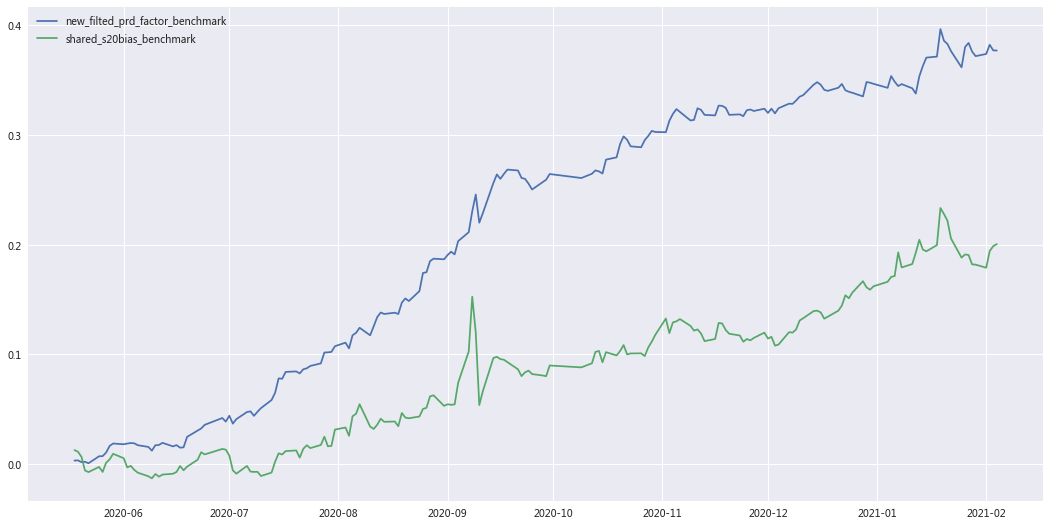

In [3]:
factor_li = [new_name,'new_filted_prd_factor_benchmark']
start_date = '20200518'
end_date = '20210204'
backtest_name = 'backtest_new_benchmark'

shared_list = []
for fct in factor_li:
    backtest_factors(fct)

li = []
for ele in shared_list:
    li.append(ele)
unsorted_df = pd.DataFrame(li,columns=['factor_name','sharpe_ratio','cum_ret'])
sorted_by='cum_ret'
sorted_df = unsorted_df.sort_values(by=sorted_by,ascending=False)
# sorted_df.to_csv('filter_factor_result_df/'+backtest_name+'.csv')

sorted_factor_li = sorted_df.factor_name

# plot_one = True:将所有alpha曲线画在同一个图中
# sorted_by = 'sharpe_ratio' or 'cum_ret'
backtest_batch_service.batch_analysis(backtest_name,sorted_factor_li,plot_one=True)
